# Generative Model

This notebook deals with finding a good generative model.

# TODO: VAE, Diffusion Model & (Sharpening U-Net GAN)

In [1]:
# Imports
import import_ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchsummary import summary
from utils import DEVICE, classes, train_data, test_data, BaseModule, train_transforms, QuickDrawDataset # type: ignore
import os
import polars as pl
import matplotlib.pyplot as plt
import umap.umap_ as umap
import warnings
from torchvision.transforms import v2
import torch.optim as optim

Mean: tensor([0.1982])
Std: tensor([0.3426])


In [2]:
# Global variables

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 100
ALPHA = 0.1
NOISE_DIM = 100
GAN_LATENT_DIM = 100
# Data loaders
TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)
TEST_LOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

# LR scheduler lambda function
def lr_lambda(epoch):
    return 0.95 ** (epoch - 1)

## Conditional Variatonal Autoencoder

First of all I want to start with a CNN-based variatonal Autoencoder. This way I can apply the knowledge that I gained while building the Classifier Model earlier.

In [3]:
# VAE loss function - combines reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD, (BCE + beta * KLD)

In [54]:
# Define the Conditional Variational Autoencoder (CVAE) model
class CVAE(nn.Module):
    def __init__(self, latent_dim=100, num_classes=len(classes)):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # label embedding to inject the information into the encoder
        self.label_embed_conv = nn.Linear(num_classes, 28 * 28)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),  # 1 channel image + 1 channel label map
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),
        )

        # Latent mappings
        self.fc_input_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim + num_classes, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.3),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    # Reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        batch_size = x.size(0)

        # One-hot label to image-size label map
        y_onehot = F.one_hot(y, self.num_classes).float().to(x.device)
        y_map = self.label_embed_conv(y_onehot).view(batch_size, 1, 28, 28)

        # Concatenate image and label map
        x_cat = torch.cat([x, y_map], dim=1)

        x_encoded = self.encoder(x_cat)
        x_flat = x_encoded.view(batch_size, -1)

        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        z = self.reparameterize(mu, logvar)

        # Decode
        z_cat = torch.cat([z, y_onehot], dim=1)
        x_decoded = self.fc_decode(z_cat)
        x_decoded = x_decoded.view(batch_size, 64, 7, 7)
        recon_x = self.decoder(x_decoded)

        return recon_x, mu, logvar, z

    def sample(self, z, y):
        y_onehot = F.one_hot(y, self.num_classes).float().to(z.device)
        z_cat = torch.cat([z, y_onehot], dim=1)
        x_decoded = self.fc_decode(z_cat)
        x_decoded = x_decoded.view(z.size(0), 64, 7, 7)
        samples = self.decoder(x_decoded)
        return samples

In [34]:
def kl_anneal(epoch, total_epochs, max_beta=1.0):
    """Linear annealing from 0 to max_beta"""
    return min(max_beta, max_beta * epoch / total_epochs)


In [5]:
def sample_conditional_images(model, epoch, num_classes=5, latent_dim=50, device=DEVICE):
    with torch.no_grad():
        z = torch.randn(num_classes, latent_dim).to(device)
        y = torch.arange(num_classes).to(device)
        samples = model.sample(z, y).cpu()

        _, axes = plt.subplots(1, num_classes, figsize=(num_classes*2, 2))
        for i in range(num_classes):
            ax = axes[i]
            ax.imshow(samples[i].squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(classes[i])

        plt.suptitle(f'Sampled Images at Epoch {epoch}', y=1.05)
        plt.subplots_adjust(top=0.8)
        plt.show()

In [6]:
# Plots a UMAP projection to visualize the latent space of the model
def plot_umap(z_all, y_all, epoch, class_names):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        reducer = umap.UMAP(n_components=2, random_state=None)
    z_2d = reducer.fit_transform(z_all)

    # Get unique classes sorted to align with colorbar ticks
    unique_classes = sorted(set(y_all))

    # Create a dict mapping class index to name
    class_labels = [class_names[c] for c in unique_classes]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_all, cmap='tab10', alpha=0.6)

    # Setup colorbar with ticks and labels
    cbar = plt.colorbar(scatter, ticks=unique_classes)
    cbar.ax.set_yticklabels(class_labels)

    plt.title(f't-SNE Projection of Latent Space at Epoch {epoch}')
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.show()


Epoch 1 | Learning Rate 0.0010
Loss: 494.6105 | Reconstruction Loss: 494.6105 | KL Divergence: 1404.4871
Epoch 2 | Learning Rate 0.0010
Loss: 489.6196 | Reconstruction Loss: 486.6942 | KL Divergence: 390.0529
Epoch 3 | Learning Rate 0.0010
Loss: 473.7422 | Reconstruction Loss: 470.9821 | KL Divergence: 184.0110
Epoch 4 | Learning Rate 0.0010
Loss: 468.7465 | Reconstruction Loss: 465.7930 | KL Divergence: 131.2632
Epoch 5 | Learning Rate 0.0010
Loss: 460.9281 | Reconstruction Loss: 457.5090 | KL Divergence: 113.9701
Epoch 6 | Learning Rate 0.0010
Loss: 464.4125 | Reconstruction Loss: 460.4221 | KL Divergence: 106.4115
Epoch 7 | Learning Rate 0.0010
Loss: 467.5361 | Reconstruction Loss: 462.7633 | KL Divergence: 106.0622
Epoch 8 | Learning Rate 0.0010
Loss: 451.6958 | Reconstruction Loss: 446.3664 | KL Divergence: 101.5134
Epoch 9 | Learning Rate 0.0010
Loss: 466.2854 | Reconstruction Loss: 460.2732 | KL Divergence: 100.2029
Epoch 10 | Learning Rate 0.0010
Loss: 466.5759 | Reconstruction

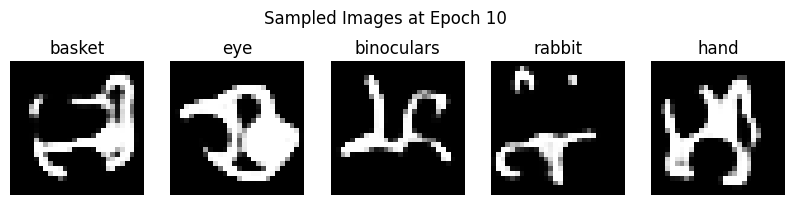

Epoch 11 | Learning Rate 0.0010
Loss: 475.8627 | Reconstruction Loss: 468.4706 | KL Divergence: 98.5613
Epoch 12 | Learning Rate 0.0010
Loss: 452.3862 | Reconstruction Loss: 444.7722 | KL Divergence: 92.2904
Epoch 13 | Learning Rate 0.0010
Loss: 454.4754 | Reconstruction Loss: 445.9196 | KL Divergence: 95.0645
Epoch 14 | Learning Rate 0.0010
Loss: 464.6582 | Reconstruction Loss: 455.7041 | KL Divergence: 91.8371
Epoch 15 | Learning Rate 0.0010
Loss: 471.5575 | Reconstruction Loss: 461.7168 | KL Divergence: 93.7211
Epoch 16 | Learning Rate 0.0010
Loss: 453.1899 | Reconstruction Loss: 443.0174 | KL Divergence: 90.4221


KeyboardInterrupt: 

In [56]:
# Training and evaluation loop for the CVAE model

kl = []
recon = []
loss = []

# Beta parameter for KL divergence weighting
"""
beta = 5 caused KL Divergence to collapse
beta = 2 training plateaued after 10 epochs
"""
beta = 1.5

model = CVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.9)
# Params for early stopping
best_loss = float('inf')
epochs_no_improve = 0

# Create directories for saving weights if they don't exist
os.makedirs(os.path.dirname(f'../weights/generative/cvae.pt'), exist_ok=True)

model.train()
for epoch in range(NUM_EPOCHS):

    z_all = []
    y_all = []

    for i, (x, labels) in enumerate(TRAIN_LOADER):
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)

        x_reconst, mu, log_var, z = model(x,labels)
        current_beta = kl_anneal(epoch, NUM_EPOCHS, beta)
        reconst_loss, kl_div, train_loss = vae_loss(x_reconst, x, mu, log_var, current_beta)

        recon.append(reconst_loss.item()/len(x))
        kl.append(kl_div.item()/len(x))
        loss.append(train_loss.item()/len(x))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        z_all.append(z.detach().cpu())
        y_all.append(labels.detach().cpu())

    #scheduler.step(train_loss)

    # Early stopping logic
    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        torch.save(model, f'../weights/generative/cvae.pt')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1} | Learning Rate {optimizer.param_groups[0]['lr']:.4f}\n"
        f"Loss: {train_loss.item()/len(x):.4f} | "
        f"Reconstruction Loss: {reconst_loss.item()/len(x):.4f} | "
        f"KL Divergence: {kl_div.item()/len(x):.4f}")


    if (epoch + 1) % 10 == 0:
        model.eval()
        if (epoch + 1) % 50 == 0:
            # Visualize the latent space using UMAP
            z_all = torch.cat(z_all)
            y_all = torch.cat(y_all)
            plot_umap(z_all.numpy(), y_all.numpy(), epoch + 1, classes)
        sample_conditional_images(model, epoch + 1, model.num_classes, model.latent_dim, DEVICE)
        model.train()

In [4]:
# The GAN expected images with values from [-1, 1] so we need different normalizations
cgan_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5], [0.5])
])

# Add data augmentations during training
cgan_train_transforms = v2.Compose([
    *train_transforms.transforms[:-3],
    *cgan_transforms.transforms
])

# cGAN Dataset and Dataloader
cgan_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', cgan_train_transforms)
cgan_test_data = QuickDrawDataset('../dataset/test.csv', '../dataset/images', cgan_transforms)

cgan_train_loader = DataLoader(cgan_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)
cgan_test_loader = DataLoader(cgan_test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)
    
# The Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=5, embedding_dim=GAN_LATENT_DIM):
        super(ConditionalGenerator, self).__init__()

        # Conditional Part: Embedd label and add concat with input
        self.label_embed = nn.Embedding(num_classes, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(noise_dim * 2, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True)
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 7x7 → 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(0.3),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 14x14 → 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), 
            nn.Tanh()  # normalize output to [-1, 1]
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        x = self.fc(x).view(-1, 256, 7, 7)
        return self.net(x)

# The Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=5, embedding_dim=GAN_LATENT_DIM):
        super(ConditionalDiscriminator, self).__init__()

        # Conditional Part: Embedd label and add concat with input
        self.label_embed = nn.Embedding(num_classes, embedding_dim)
        self.label_fc = nn.Linear(embedding_dim, 28 * 28)

        self.net = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # 28x28 → 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14x14 → 7x7
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        label_img = self.label_fc(label_embedding).view(-1, 1, 28, 28)
        x = torch.cat([img, label_img], dim=1)  # concat on channel dim
        return self.net(x)


## Conditional GAN

Based on this [paper](https://arxiv.org/pdf/1511.06434) I want to build a conditional version that is able to create images

In [11]:
def sample_images(generator, noise, image_labels, epoch):
    
    with torch.no_grad():
        generated_images = generator(noise, image_labels) 
        generated_images = generated_images * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]

    # Plot
    # Get model predictions -> logits
    _, axs = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        img = generated_images[i]
        img = img.squeeze(0).cpu()

        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class {classes[image_labels[i].item()]}")
        ax.axis('off')
        
    plt.suptitle(f'Sampled Images at Epoch {epoch}')
    plt.show()

Epoch 1 | Loss_D: 0.4578 | Loss_G: 2.2961


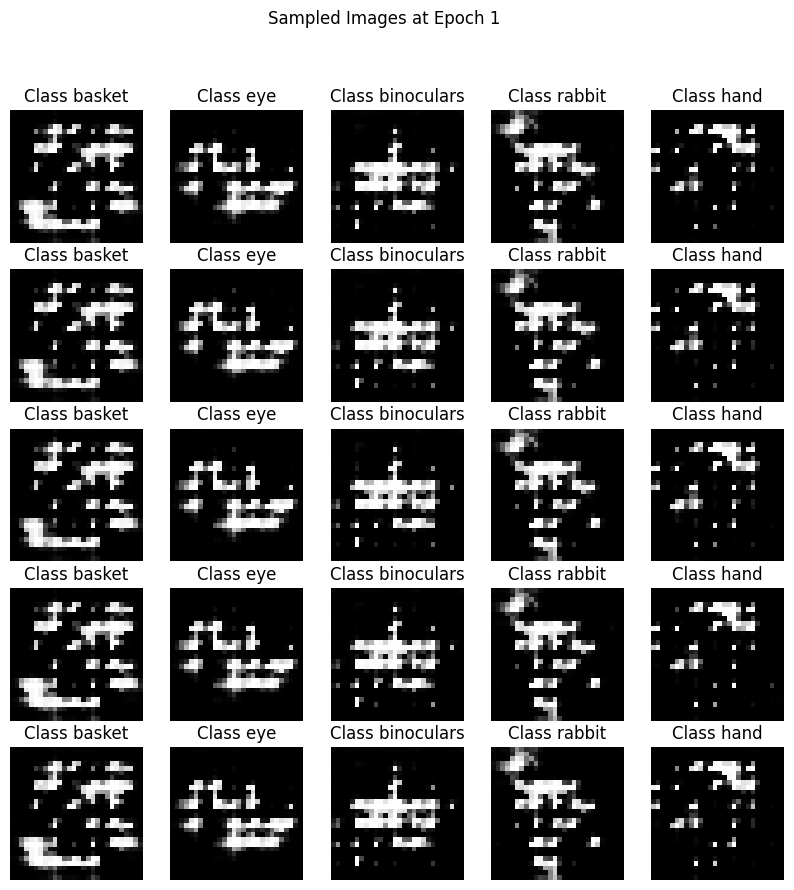

Epoch 2 | Loss_D: 0.4750 | Loss_G: 2.0432
Epoch 3 | Loss_D: 0.4688 | Loss_G: 1.8270
Epoch 4 | Loss_D: 0.4768 | Loss_G: 1.6892
Epoch 5 | Loss_D: 0.4727 | Loss_G: 1.5233
Epoch 6 | Loss_D: 0.4530 | Loss_G: 1.4913
Epoch 7 | Loss_D: 0.4308 | Loss_G: 1.6263
Epoch 8 | Loss_D: 0.4587 | Loss_G: 2.2625
Epoch 9 | Loss_D: 0.4575 | Loss_G: 1.4114
Epoch 10 | Loss_D: 0.4291 | Loss_G: 2.0109
Epoch 11 | Loss_D: 0.4300 | Loss_G: 1.8335


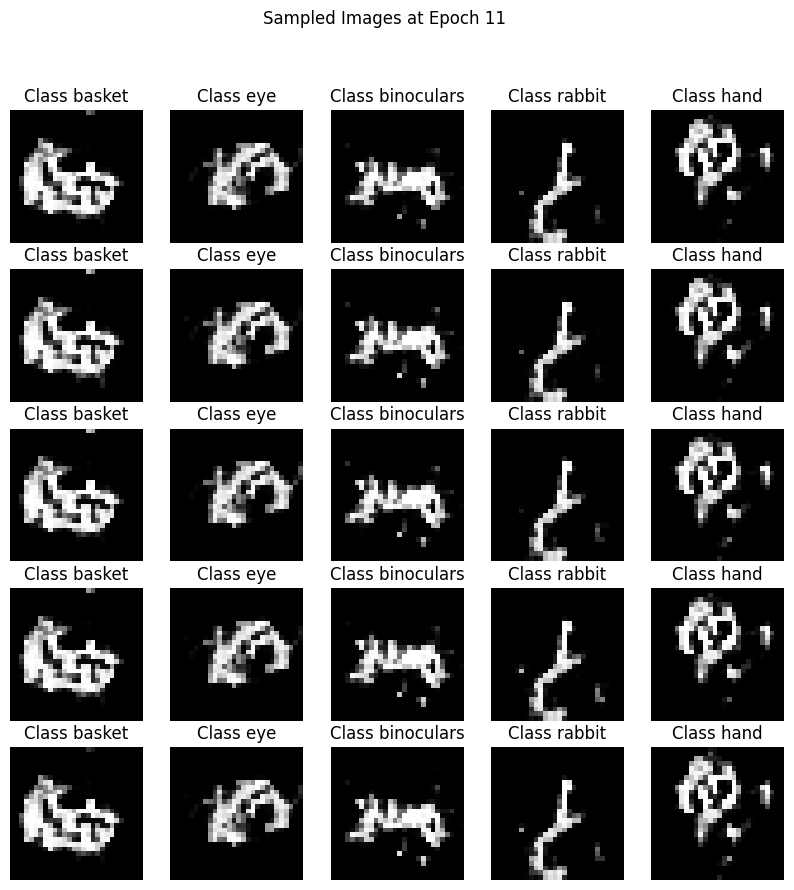

Epoch 12 | Loss_D: 0.4302 | Loss_G: 1.7372
Epoch 13 | Loss_D: 0.4372 | Loss_G: 1.5009
Epoch 14 | Loss_D: 0.4123 | Loss_G: 1.5262
Epoch 15 | Loss_D: 0.4119 | Loss_G: 1.7051
Epoch 16 | Loss_D: 0.4186 | Loss_G: 1.5723
Epoch 17 | Loss_D: 0.4055 | Loss_G: 2.0511
Epoch 18 | Loss_D: 0.4076 | Loss_G: 1.7157
Epoch 19 | Loss_D: 0.4205 | Loss_G: 2.1311
Epoch 20 | Loss_D: 0.4330 | Loss_G: 2.0372
Epoch 21 | Loss_D: 0.4076 | Loss_G: 1.6820


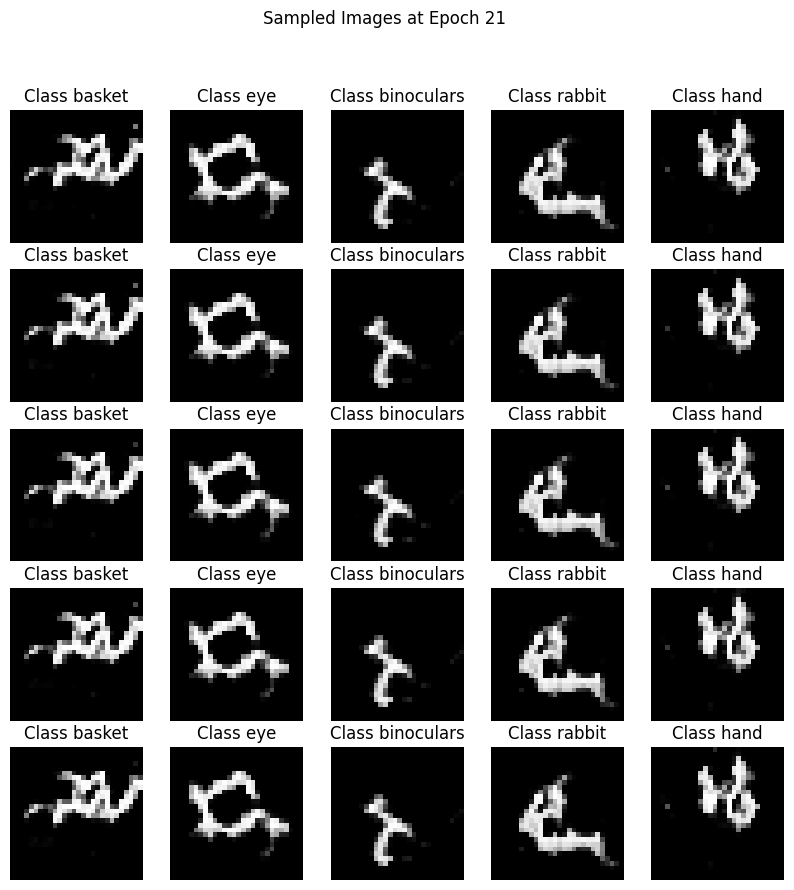

Epoch 22 | Loss_D: 0.4020 | Loss_G: 2.0198
Epoch 23 | Loss_D: 0.4044 | Loss_G: 1.9491
Epoch 24 | Loss_D: 0.4359 | Loss_G: 2.1247
Epoch 25 | Loss_D: 0.4118 | Loss_G: 1.7338
Epoch 26 | Loss_D: 0.4176 | Loss_G: 2.0451
Epoch 27 | Loss_D: 0.4110 | Loss_G: 2.1941
Epoch 28 | Loss_D: 0.4049 | Loss_G: 1.9162
Epoch 29 | Loss_D: 0.3961 | Loss_G: 1.9862
Epoch 30 | Loss_D: 0.4008 | Loss_G: 1.7567
Epoch 31 | Loss_D: 0.4019 | Loss_G: 1.7594


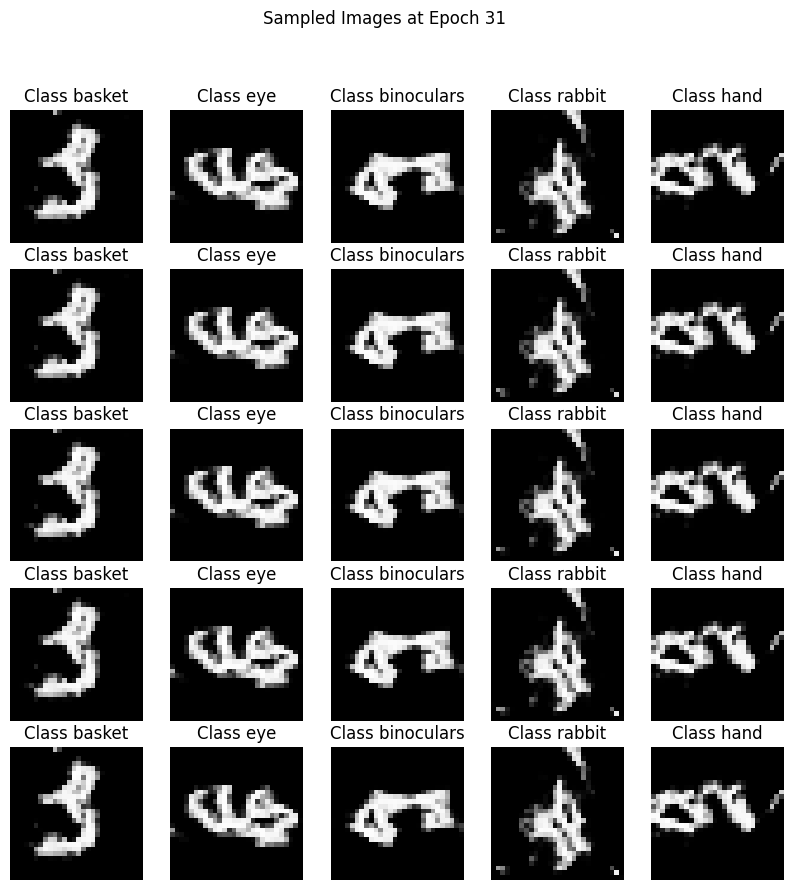

Epoch 32 | Loss_D: 0.3941 | Loss_G: 1.7138
Epoch 33 | Loss_D: 0.4173 | Loss_G: 2.3220
Epoch 34 | Loss_D: 0.4176 | Loss_G: 1.7821
Epoch 35 | Loss_D: 0.4052 | Loss_G: 1.7222
Epoch 36 | Loss_D: 0.4195 | Loss_G: 1.7211
Epoch 37 | Loss_D: 0.4081 | Loss_G: 1.5796
Epoch 38 | Loss_D: 0.4153 | Loss_G: 1.9234
Epoch 39 | Loss_D: 0.4038 | Loss_G: 1.6414
Epoch 40 | Loss_D: 0.4049 | Loss_G: 1.9706
Epoch 41 | Loss_D: 0.4029 | Loss_G: 1.7959


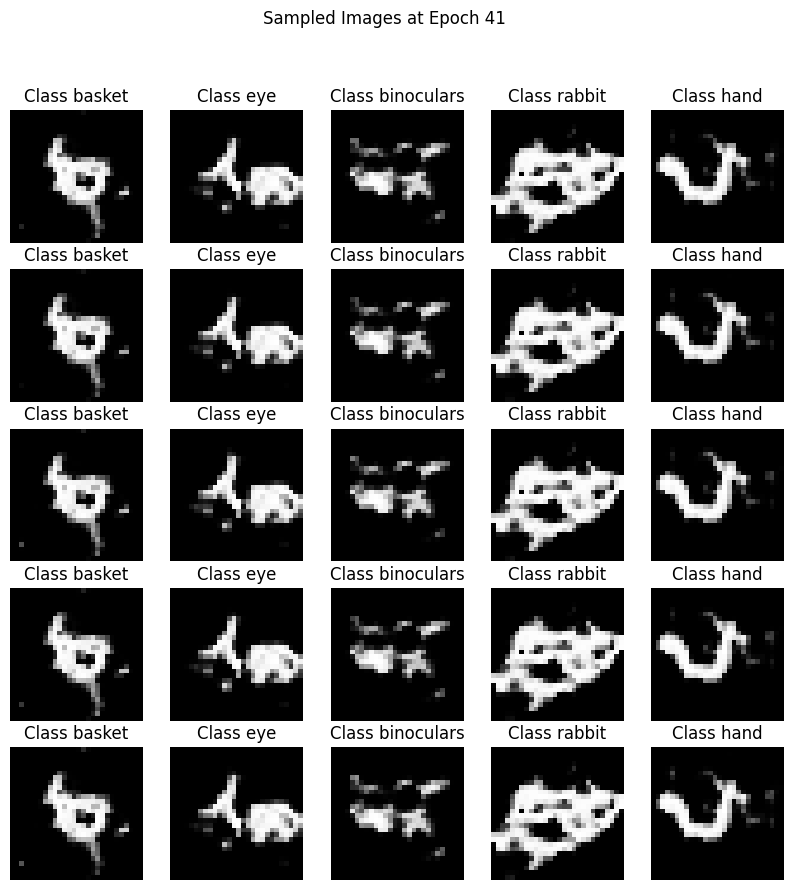

Epoch 42 | Loss_D: 0.4185 | Loss_G: 1.8645
Epoch 43 | Loss_D: 0.4182 | Loss_G: 1.7899
Epoch 44 | Loss_D: 0.4109 | Loss_G: 1.7212
Epoch 45 | Loss_D: 0.4178 | Loss_G: 1.8442
Epoch 46 | Loss_D: 0.4060 | Loss_G: 1.8356
Epoch 47 | Loss_D: 0.4073 | Loss_G: 1.8597
Epoch 48 | Loss_D: 0.4148 | Loss_G: 1.9072
Epoch 49 | Loss_D: 0.3970 | Loss_G: 1.8184
Epoch 50 | Loss_D: 0.3990 | Loss_G: 1.6950
Epoch 51 | Loss_D: 0.3767 | Loss_G: 1.8037


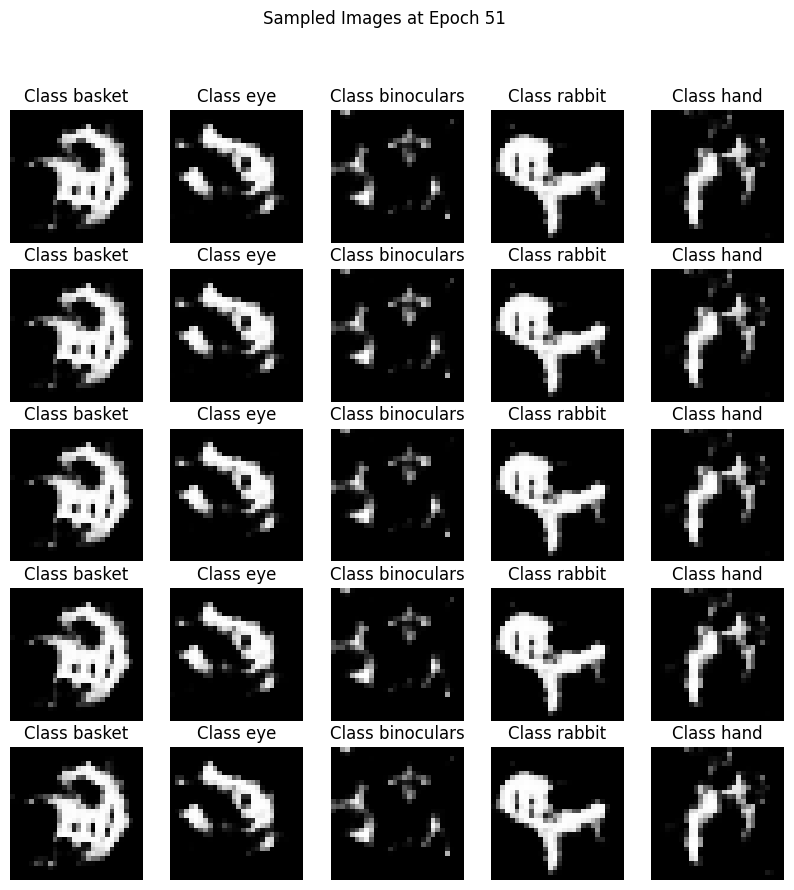

Epoch 52 | Loss_D: 0.4171 | Loss_G: 2.0468
Epoch 53 | Loss_D: 0.4031 | Loss_G: 1.6876
Epoch 54 | Loss_D: 0.4028 | Loss_G: 2.1847
Epoch 55 | Loss_D: 0.4267 | Loss_G: 1.9090
Epoch 56 | Loss_D: 0.4120 | Loss_G: 2.0256
Epoch 57 | Loss_D: 0.3914 | Loss_G: 1.9306
Epoch 58 | Loss_D: 0.3994 | Loss_G: 2.0261
Epoch 59 | Loss_D: 0.3937 | Loss_G: 1.8802
Epoch 60 | Loss_D: 0.4052 | Loss_G: 1.9988
Epoch 61 | Loss_D: 0.4006 | Loss_G: 1.8351


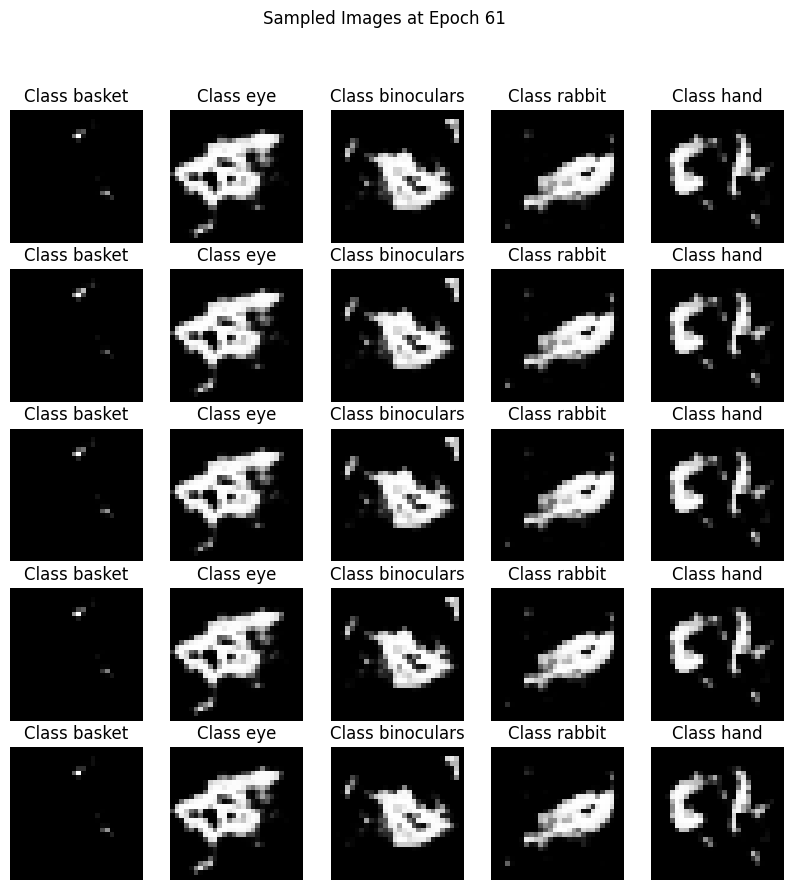

Epoch 62 | Loss_D: 0.3903 | Loss_G: 2.2333
Epoch 63 | Loss_D: 0.4183 | Loss_G: 1.8194
Epoch 64 | Loss_D: 0.3998 | Loss_G: 2.1541
Epoch 65 | Loss_D: 0.4072 | Loss_G: 1.7584
Epoch 66 | Loss_D: 0.3927 | Loss_G: 1.5239
Epoch 67 | Loss_D: 0.3999 | Loss_G: 1.9000
Epoch 68 | Loss_D: 0.4141 | Loss_G: 2.1213
Epoch 69 | Loss_D: 0.4005 | Loss_G: 1.7445
Epoch 70 | Loss_D: 0.3914 | Loss_G: 1.8916
Epoch 71 | Loss_D: 0.4179 | Loss_G: 1.4559


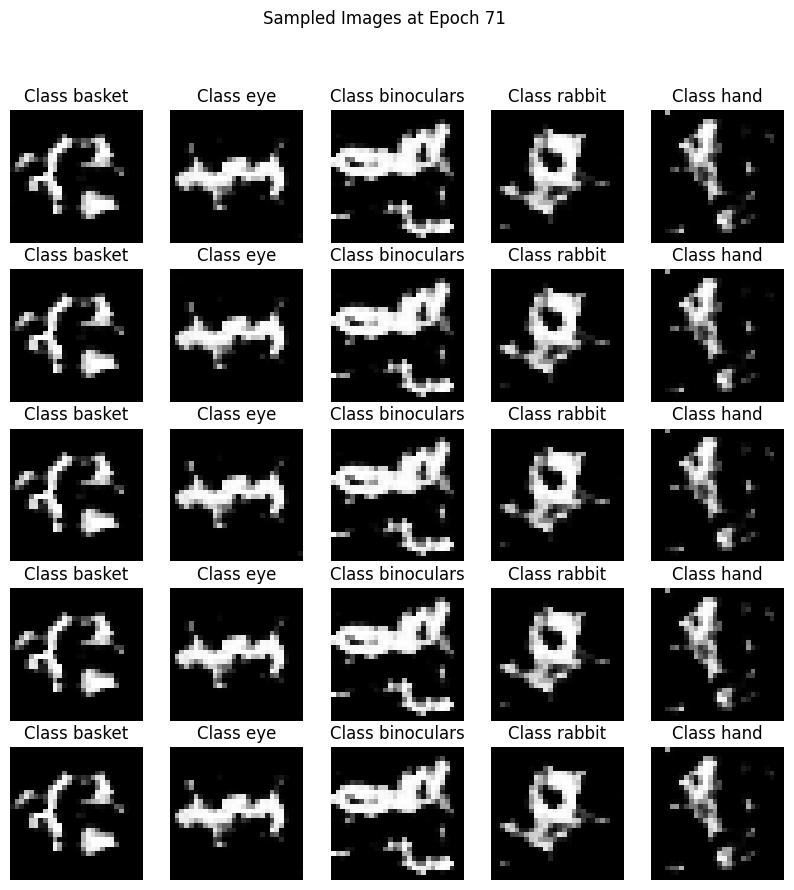

Epoch 72 | Loss_D: 0.3856 | Loss_G: 1.6130
Epoch 73 | Loss_D: 0.4082 | Loss_G: 1.9483
Epoch 74 | Loss_D: 0.3890 | Loss_G: 1.7953
Epoch 75 | Loss_D: 0.4265 | Loss_G: 2.4094
Epoch 76 | Loss_D: 0.4051 | Loss_G: 1.8587
Epoch 77 | Loss_D: 0.3933 | Loss_G: 2.0249
Epoch 78 | Loss_D: 0.4049 | Loss_G: 1.9569
Epoch 79 | Loss_D: 0.3961 | Loss_G: 1.6890
Epoch 80 | Loss_D: 0.4158 | Loss_G: 1.5771
Epoch 81 | Loss_D: 0.4065 | Loss_G: 1.5250


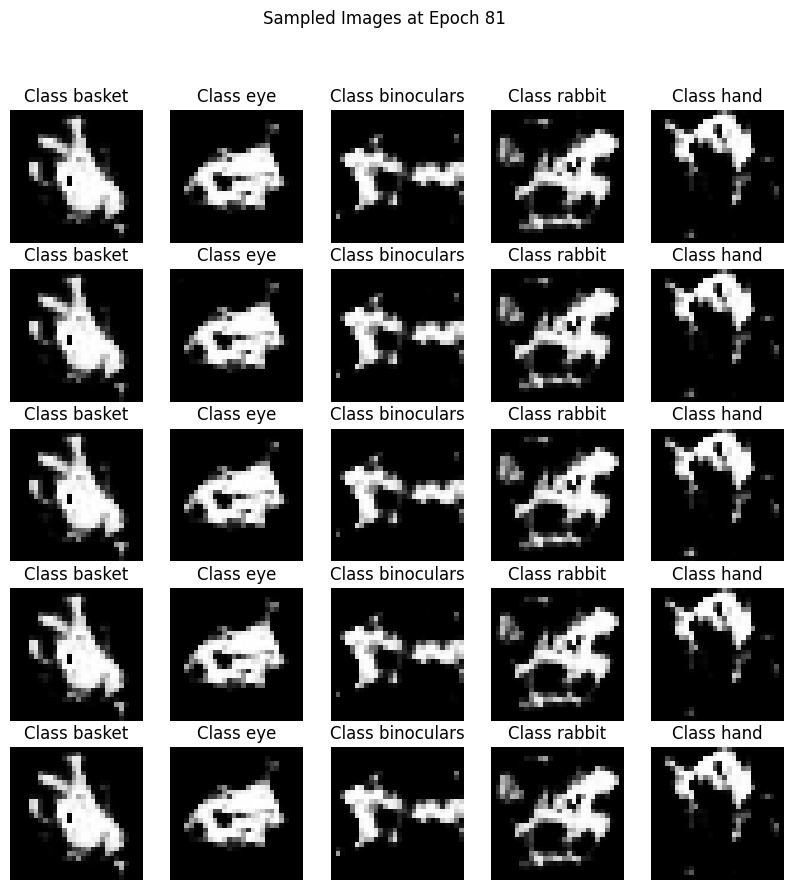

Epoch 82 | Loss_D: 0.3997 | Loss_G: 1.7380
Epoch 83 | Loss_D: 0.4183 | Loss_G: 1.9166
Epoch 84 | Loss_D: 0.4012 | Loss_G: 1.9764
Epoch 85 | Loss_D: 0.3831 | Loss_G: 1.7363
Epoch 86 | Loss_D: 0.4021 | Loss_G: 1.8997
Epoch 87 | Loss_D: 0.4043 | Loss_G: 1.6827
Epoch 88 | Loss_D: 0.3952 | Loss_G: 1.7721
Epoch 89 | Loss_D: 0.3821 | Loss_G: 1.6603
Epoch 90 | Loss_D: 0.3899 | Loss_G: 1.6613
Epoch 91 | Loss_D: 0.4063 | Loss_G: 1.7823


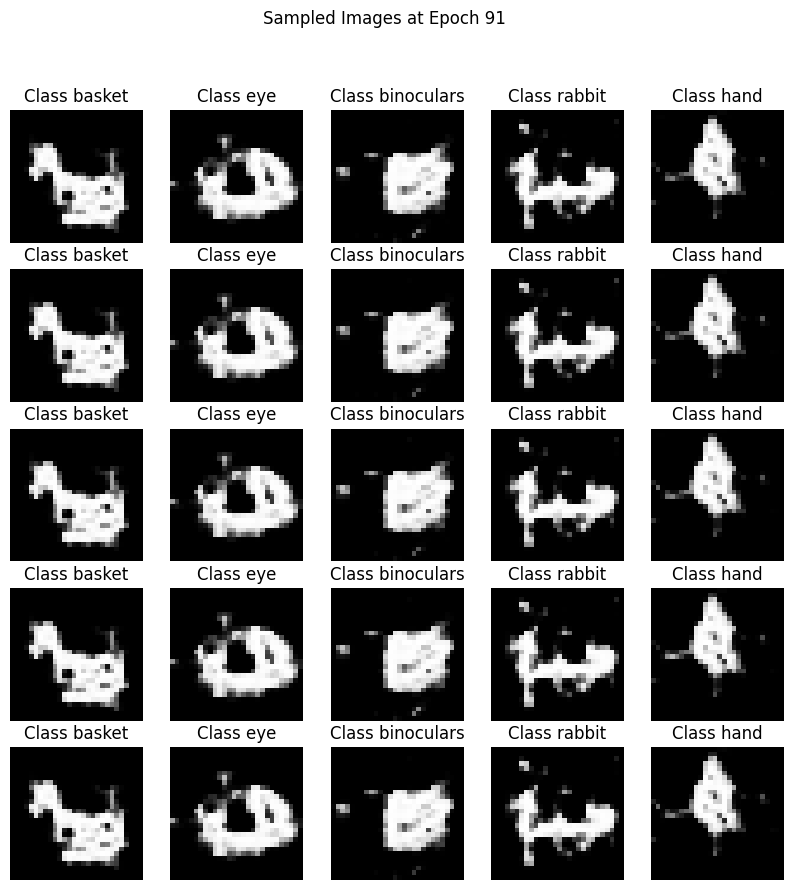

Epoch 92 | Loss_D: 0.4004 | Loss_G: 1.7456
Epoch 93 | Loss_D: 0.3931 | Loss_G: 1.9247
Epoch 94 | Loss_D: 0.3992 | Loss_G: 1.7516
Epoch 95 | Loss_D: 0.4155 | Loss_G: 2.1566
Epoch 96 | Loss_D: 0.3934 | Loss_G: 1.8214
Epoch 97 | Loss_D: 0.3877 | Loss_G: 1.8229
Epoch 98 | Loss_D: 0.3991 | Loss_G: 1.7849
Epoch 99 | Loss_D: 0.4212 | Loss_G: 1.9800
Epoch 100 | Loss_D: 0.4004 | Loss_G: 2.1690


In [13]:
# Init models
G = ConditionalGenerator(noise_dim=NOISE_DIM, num_classes=len(classes)).to(DEVICE)
D = ConditionalDiscriminator(num_classes=NOISE_DIM).to(DEVICE)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Pregenerated fixed nose and fixed labels to check if generation improves
fixed_noise = torch.randn(25, NOISE_DIM, device=DEVICE)
fixed_image_labels = torch.arange(0, len(classes)).repeat(5).to(DEVICE)

for epoch in range(0, NUM_EPOCHS):
    for i, (real_imgs, image_labels) in enumerate(cgan_train_loader):
        real_imgs = real_imgs.to(DEVICE)
        image_labels = image_labels.to(DEVICE)

        # Add a bit of gaussian noice to images in order to prevent the discriminator from becoming to good
        # Decay the added noise over time
        noise_std = max(0.1 * (1.0 - epoch / NUM_EPOCHS), 0.01)
        instance_noise = torch.randn_like(real_imgs) * noise_std
        noisy_real_images = real_imgs + instance_noise

        # Train Discriminator
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(BATCH_SIZE, GAN_LATENT_DIM, device=DEVICE)
        fake_image_labels = image_labels
        fake_images = G(z, fake_image_labels)

        # Add instance noise to fake images
        noisy_fake_images = fake_images + torch.randn_like(fake_images) * noise_std

        # Fake labels in [0.0, 0.25]
        fake_d_labels = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.0, 0.25)
        
        # Generate real labels in [0.75, 1.0] - prevent discriminator  overconfidence
        real_d_labels = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.75, 1.0)

        # Sh real and fake images to prevent ordering bias
        all_images = torch.cat([noisy_real_images, noisy_fake_images], dim=0)
        all_image_labels = torch.cat([image_labels, fake_image_labels], dim=0)
        all_d_labels = torch.cat([real_d_labels, fake_d_labels], dim=0)

        perm = torch.randperm(all_images.size(0))
        shuffled_images = all_images[perm]
        shuffled_image_labels = all_image_labels[perm]
        shuffled_d_labels = all_d_labels[perm]

        outputs = D(shuffled_images, shuffled_image_labels)
        loss_D = criterion(outputs.view(-1), shuffled_d_labels)
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images again
        fake_images = G(z, fake_image_labels)

        # Get discriminator's prediction on these fake images with their labels
        outputs = D(fake_images, fake_image_labels)

        # Generator wants the discriminator to believe these are real
        gen_targets = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.75, 1.0)

        # Compute generator loss 
        loss_G = criterion(outputs.view(-1), gen_targets)
        
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1} | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

    # Save sample images
    if epoch % 10 == 0:
        G.eval()
        sample_images(G, fixed_noise, fixed_image_labels, epoch+1)
        G.train()

## Non-conditional GAN

Maybe training the generator to produce output for every class is less efficient then just training five smaller models.

In [ ]:
class_label

## Conditional Diffusion Model